In [1]:
import graphviz
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import cython
import tweepy
import json
import requests
import inspect
import re
from tqdm import tqdm
from time import time, sleep
import networkx as nx

In [2]:
from ast import literal_eval

data = pd.read_csv("politicians_connections_two.csv")
print(data)
data["Following"] = data["Following"].apply(literal_eval)

print(data)

usernames = data["Username"].tolist()
ids = data["ids"].tolist()

          Party                      Name  Branch        Username  \
0    Republican             Pete Sessions   House    PeteSessions   
1    Democratic            Debbie Dingell   House   RepDebDingell   
2    Democratic           Pramila Jayapal   House      RepJayapal   
3    Republican               Rob Wittman   House      RobWittman   
4    Democratic           Chellie Pingree   House  chelliepingree   
..          ...                       ...     ...             ...   
521  Republican               Thom Tillis  Senate   SenThomTillis   
522  Republican         Diana Harshbarger   House  RepHarshbarger   
523  Republican          Tommy Tuberville  Senate   SenTuberville   
524  Democratic  Debbie Wasserman Schultz   House    RepDWStweets   
525  Republican              Lisa McClain   House  RepLisaMcClain   

                     ids                                          Following  
0               24735461  {'ids': [1396151678, 815966620300480514, 12912...  
1             2

In [3]:
dot = nx.Graph()

politician_ids = []

for i, user_following in enumerate(data["Following"]):
    
    # if data["Branch"][i] != "Senate":
    #     continue
    
    user_id = str(data["Username"][i])
    user_screen_name = data["Name"][i]
    user_party = data["Party"][i][0]
    user_branch = data["Branch"][i][0]
    
    
    politician_ids.append(user_id)
    
    dot.add_node(user_id, Party=user_party, Branch=user_branch, Screenname = user_screen_name)


pbar =  tqdm(data["Following"])

n_edges = 0

for i, user_following in enumerate(pbar):

    # if data["Branch"][i] != "Senate":
    #     continue
    
    user_id = data["Username"][i]
    user_party = data["Party"][i]
    
    following_ids = user_following["usernames"]
    
    following_ids = list(map(str, following_ids))
    following_ids = [x for x in following_ids if x in politician_ids]
    
    for n, id in enumerate(following_ids):
        
        if user_party == "Democratic":
            edgefrom = "Dem"
        else:
            edgefrom = "Rep"
        
        dot.add_edge(user_id, str(id), edgefrom=edgefrom)
        n_edges += 1


    pbar.set_description(f"{n_edges} edges so far")
    
#dot.render(directory='doctest-output', view=True)  
#

67903 edges so far: 100%|████████████████████████| 526/526 [00:04<00:00, 117.47it/s]


In [4]:
# fig, subplot = plt.subplots(figsize = (12,12))

# pos = nx.spring_layout(dot)

# #subax1 = plt.subplot(121)

# nx.draw_networkx(dot,pos = pos, with_labels=True)#, font_weight='bold')
# plt.show()

In [5]:
nx.write_gml(dot, "politicians.gml")

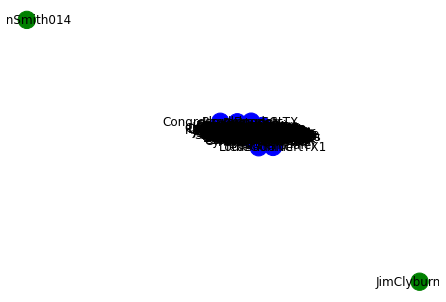

In [6]:
def edge_to_remove(graph):
    G_dict = nx.edge_betweenness_centrality(graph)
    edge = ()

    # extract the edge with highest edge betweenness centrality score
    for key, value in sorted(G_dict.items(), key=lambda item: item[1], reverse = True):
        edge = key
        break

    return edge

def girvan_newman(graph):
    # find number of connected components
    sg = nx.connected_components(graph)
    sg_count = nx.number_connected_components(graph)

    while(sg_count == 1):
        graph.remove_edge(edge_to_remove(graph)[0], edge_to_remove(graph)[1])
        sg = nx.connected_components(graph)
        sg_count = nx.number_connected_components(graph)

    return sg

c = girvan_newman(dot.copy())

# find the nodes forming the communities
node_groups = []

for i in c:
    node_groups.append(list(i))

# plot the communities
color_map = []
for node in dot:
    if node in node_groups[0]:
        color_map.append('blue')
    else: 
        color_map.append('green')  

nx.draw(dot, node_color=color_map, with_labels=True)
plt.show()

In [7]:
import networkx.algorithms.community as com

cliques = list(com.k_clique_communities(dot, 100))
print(set(cliques))


KeyboardInterrupt: 